In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
from tqdm import tqdm
import hiplot as hip
import gc

In [3]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset

In [4]:
cwd = os.getcwd()
print(cwd)

/cluster/home/skyriakos/chemprop_run/git/notebooks


In [5]:
os.chdir('..')
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
# from deepadr.model_gnn import GCN as testGCN
from deepadr.model_gnn_ogb import GNN, DeepAdr_SiameseTrf, ExpressionNN
# from deepadr.model_attn_siamese import *
from ogb.graphproppred import Evaluator
os.chdir(cwd)

In [6]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [7]:
# from tdc.single_pred import Tox
# from tdc.multi_pred import DDI

In [8]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [9]:
report_available_cuda_devices()

number of GPUs available: 8
cuda:0, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:1, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:2, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:3, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:4, name:GeForce GTX 1080 Ti
total memory av

In [10]:
n_gpu = torch.cuda.device_count()
n_gpu

8

In [11]:
device_cpu = get_device(to_gpu=False)
device_gpu = get_device(True, index=0)

fdtype = torch.float32

In [12]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)

torch: 1.9.1
CUDA: 11.1


In [13]:
# print(torch.cuda.memory_summary(device=device_gpu))

### Preparing dataset 

In [14]:
# TDC Tox
DSdataset_name = 'SynergxZloewe' #'OncoPolyPharmacology' #'DrugComb'

#fname_suffix = ds_config["fname_suffix"]
similarity_types = ['chem']
kernel_option = 'sqeuclidean'
data_fname = 'data_v1'
# interact_matfname = ds_config["interact_matfname"]
# exp_iden = 'simtypeall'
# ddi_interaction_labels_pth = ds_config["ddi_interaction_labels_pth"]

# up_dir, processed_dir, DSdataset_name, data_fname

In [15]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
# # ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))
print(targetdata_dir)

path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
/cluster/home/skyriakos/chemprop_run/git/data/processed/SynergxZloewe/data_v1


In [16]:
%%time

# Make sure to first run the "data_generation" notebook first

dataset = MoleculeDataset(root=targetdata_dir)

CPU times: user 12.4 ms, sys: 420 ms, total: 433 ms
Wall time: 424 ms


In [17]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data0 = dataset[0]  # Get the first graph object.

# print()
# print(data)
# print('=============================================================')

# # Gather some statistics about the first graph.
# print(f'Number of nodes: {data.num_nodes}')
# print(f'Number of edges: {data.num_edges}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
# print(f'Contains self-loops: {data.contains_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: MoleculeDataset(75960):
Number of graphs: 75960
Number of features: 9
Number of classes: 2


In [18]:
data0

PairData(edge_index_a=[2, 44], x_a=[22, 9], edge_attr_a=[44, 3], edge_index_b=[2, 18], x_b=[9, 9], edge_attr_b=[18, 3], id=[1], y=[1], expression=[1, 908])

In [19]:
data0.expression.shape

torch.Size([1, 908])

In [20]:
data0.y

tensor([0], dtype=torch.int32)

In [21]:
len(dataset)

75960

In [22]:
# used_dataset = dataset

# If you want to use a smaller subset of the dataset for testing
smaller_dataset_len = int(len(dataset)/1)
used_dataset = dataset[:smaller_dataset_len]

In [23]:
fold_partitions = get_stratified_partitions(used_dataset.data.y[:smaller_dataset_len],
                                            num_folds=5, valid_set_portion=0.1, random_state=42)

fold_num: 0
train data
class: 0 norm count: 0.4793293229233329
class: 1 norm count: 0.5206706770766671
validation data
class: 0 norm count: 0.4793483626789534
class: 1 norm count: 0.5206516373210466
test data
class: 0 norm count: 0.4793312269615587
class: 1 norm count: 0.5206687730384413

-------------------------
fold_num: 1
train data
class: 0 norm count: 0.4793293229233329
class: 1 norm count: 0.5206706770766671
validation data
class: 0 norm count: 0.4793483626789534
class: 1 norm count: 0.5206516373210466
test data
class: 0 norm count: 0.4793312269615587
class: 1 norm count: 0.5206687730384413

-------------------------
fold_num: 2
train data
class: 0 norm count: 0.4793293229233329
class: 1 norm count: 0.5206706770766671
validation data
class: 0 norm count: 0.4793483626789534
class: 1 norm count: 0.5206516373210466
test data
class: 0 norm count: 0.4793312269615587
class: 1 norm count: 0.5206687730384413

-------------------------
fold_num: 3
train data
class: 0 norm count: 0.479329

In [24]:
# train_val_test_frac = [0.7, 0.1, 0.2]
# assert sum(train_val_test_frac) == 1

# torch.manual_seed(42)
# used_dataset = used_dataset.shuffle()

# num_train = round(train_val_test_frac[0] * len(used_dataset)) 
# num_trainval = round((train_val_test_frac[0]+train_val_test_frac[1]) * len(used_dataset))

# train_dataset = used_dataset[:num_train]
# val_dataset = used_dataset[num_train:num_trainval]
# test_dataset = used_dataset[num_trainval:]

In [25]:
train_dataset = Subset(used_dataset, fold_partitions[0]['train'])
val_dataset = Subset(used_dataset, fold_partitions[0]['validation'])
test_dataset = Subset(used_dataset, fold_partitions[0]['test'])

In [26]:
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 54691
Number of val graphs: 6077
Number of test graphs: 15192


In [27]:
print(dataset.num_classes)

2


In [28]:
# train_dataset[3]

In [29]:
# training params
tp = {
    "batch_size" : 300,
    "num_epochs" : 10,
    
    "emb_dim" : 300,
    "gnn_type" : "gatv2",
    "num_layer" : 5,
    "graph_pooling" : "mean", #attention
    
    "input_embed_dim" : None,
    "gene_embed_dim": 1,
    "num_attn_heads" : 2,
    "num_transformer_units" : 1,
    "p_dropout" : 0.3,
    "nonlin_func" : nn.ReLU(),
    "mlp_embed_factor" : 2,
    "pooling_mode" : 'attn',
    "dist_opt" : 'cosine',

    "base_lr" : 3e-5, #3e-4
    "max_lr_mul": 5,
    "l2_reg" : 1e-7,
    "loss_w" : 0.1,
    "margin_v" : 1.,

    "expression_dim" : 64,
    "expression_input_size" : 908,
    "exp_H1" : 500,
    "exp_H2" : 400
}

In [30]:
train_loader = DataLoader(train_dataset, batch_size=tp["batch_size"], shuffle=True, follow_batch=['x_a', 'x_b'])
valid_loader = DataLoader(val_dataset, batch_size=tp["batch_size"], shuffle=False, follow_batch=['x_a', 'x_b'])
test_loader = DataLoader(test_dataset, batch_size=tp["batch_size"], shuffle=False, follow_batch=['x_a', 'x_b'])

In [31]:
gnn_model = GNN(gnn_type = tp["gnn_type"], 
#                 num_tasks = dataset.num_classes, 
                num_layer = tp["num_layer"], 
                emb_dim = tp["emb_dim"], 
                drop_ratio = 0.5, 
                JK = "multilayer", #last
                graph_pooling = tp["graph_pooling"],
                virtual_node = False,
                with_edge_attr=False).to(device=device_gpu, dtype=fdtype)

In [32]:
transformer_model = DeepAdr_Transformer(input_size=tp["expression_input_size"],
                                        input_embed_dim=tp["input_embed_dim"],
                                        num_attn_heads=tp["num_attn_heads"],
                                        mlp_embed_factor=tp["mlp_embed_factor"],
                                        nonlin_func=tp["nonlin_func"],
                                        pdropout=tp["p_dropout"],
                                        num_transformer_units=tp["num_transformer_units"],
                                        pooling_mode=tp["pooling_mode"],
                                        gene_embed_dim=tp['gene_embed_dim']).to(device=device_gpu, dtype=fdtype)

# get_cuda_device_stats(0)

GeneEmbAttention pooling, gene_embed_dim: 1


In [33]:
# expression_model = ExpressionNN(D_in=tp["expression_input_size"],
#                                 H1=tp["exp_H1"], H2=tp["exp_H2"],
#                                 D_out=tp["expression_dim"], drop=0.5).to(device=device_gpu, dtype=fdtype)

In [34]:
siamese_model = DeepAdr_SiameseTrf(input_dim=tp["emb_dim"],
                                   dist=tp["dist_opt"],
                                   expression_dim=tp["expression_input_size"],
                                   gene_embed_dim=tp['gene_embed_dim'],
                                   num_classes=dataset.num_classes).to(device=device_gpu, dtype=fdtype)

# get_cuda_device_stats(0)

updated
num classes: 2


In [35]:
# lasso_input_dim = 2*tp["emb_dim"]+1+expression_input_size
# lasso_out_dim = dataset.num_classes

# lassonet_model = LassoNet(lasso_input_dim, lasso_out_dim)

In [36]:
# models_param = list(gnn_model.parameters()) + list(transformer_model.parameters()) + list(siamese_model.parameters()) + list(expression_model.parameters())
models_param = list(gnn_model.parameters()) + list(transformer_model.parameters()) + list(siamese_model.parameters())


model_name = "ogb"
models = [(gnn_model, f'{model_name}_GNN'),
          (transformer_model, f'{model_name}_Transformer'),
          (siamese_model, f'{model_name}_Siamese'),
#           (expression_model, f'{model_name}_Expression'),
#           (lassonet_model, f'{model_name}_LassoNet')
         ]
#models

# get_cuda_device_stats(0)

In [37]:
y_weights = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y_weights.pkl'))
class_weights = torch.tensor(y_weights).type(fdtype).to(device_gpu)
class_weights

tensor([1.0431, 0.9603], device='cuda:0')

In [38]:
# from IPython.display import Javascript
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

num_iter = len(train_loader)  # num_train_samples/batch_size
c_step_size = int(np.ceil(5*num_iter))  # this should be 2-10 times num_iter

base_lr = tp['base_lr']
max_lr = tp['max_lr_mul']*base_lr  # 3-5 times base_lr
optimizer = torch.optim.Adam(models_param, weight_decay=tp["l2_reg"], lr=base_lr)
cyc_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=c_step_size,
                                                mode='triangular', cycle_momentum=False)
# optimizer = torch.optim.Adam(models_param, lr=0.001)
# criterion = torch.nn.CrossEntropyLoss()

# loss_nlll = torch.nn.NLLLoss(weight=class_weights, reduction='mean')  # negative log likelihood loss
loss_nlll = torch.nn.NLLLoss(weight=class_weights, reduction='mean')  # negative log likelihood loss
loss_contrastive = ContrastiveLoss(0.5, reduction='mean')
# loss_mse = torch.nn.MSELoss()  # this is for regression mean squared loss


# evaluator = Evaluator(DSdataset_name)

In [39]:
def train():
    
#     print("train cuda sum:", torch.cuda.memory_summary())

#     get_cuda_device_stats(0)
    
    for m, m_name in models:
        m.train()

        #            for i_batch, samples_batch in enumerate(data_loader):

#     for data in train_loader:  # Iterate in batches over the training dataset.
    for i_batch, batch in enumerate(tqdm(train_loader, desc="Iteration")):
        batch = batch.to(device_gpu)

#         print("running batch:", i_batch)
        # x, edge_index, edge_attr, batch
        h_a = gnn_model(batch.x_a, batch.edge_index_a, batch.edge_attr_a, batch.x_a_batch)
        h_b = gnn_model(batch.x_b, batch.edge_index_b, batch.edge_attr_b, batch.x_b_batch)
        
#         print("h_a shape:", h_a.shape)
        
#         z_a, fattn_w_scores_a = transformer_model(h_a)
#         z_b, fattn_w_scores_b = transformer_model(h_b)
        
#         z_e = expression_model(batch.expression.type(fdtype))
        
        z_e, _ = transformer_model(torch.unsqueeze(batch.expression.type(fdtype), dim=1))
        
#         print("h_a shape:", h_a.shape)
#         print("h_b shape:", h_b.shape)
#         print("transformer_input shape:", transformer_input.shape)
#         print("z_e shape:", z_e.shape)
#         print("fattn_w_scores_e shape:", fattn_w_scores_e.shape)
        
#         print("h_a dtype:", h_a.dtype)
#         print("h_b dtype:", h_b.dtype)
#         print("z_e dtype:", z_e.dtype)
        
#         if (i_batch == 0):
#             print(torch.cuda.memory_summary(device=device_gpu))
        
        logsoftmax_scores, dist = siamese_model(h_a, h_b, z_e)
#         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
#         loss = criterion(out, samples_batch.y)  # Compute the loss.
#         print(pd.Series(batch.y.cpu()).value_counts())
        cl = loss_nlll(logsoftmax_scores, batch.y.type(torch.long))            
        dl = loss_contrastive(dist.reshape(-1), batch.y.type(fdtype))          
        loss = tp["loss_w"]*cl + (1-tp["loss_w"])*dl
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        cyc_scheduler.step() # after each batch step the scheduler
        optimizer.zero_grad()  # Clear gradients.
        

        
#     print("deleting objects...")
#     del batch, h_a, h_b, z_e, logsoftmax_scores, dist, cl, dl    
#     gc.collect() # CUDA out of memory...
#     torch.cuda.empty_cache()
    
#     get_cuda_device_stats(0)


def eval(loader, dsettype):
    
#     print("eval cuda sum (" + dsettype + "):", torch.cuda.memory_summary())
#     print("mem stat:", torch.cuda.memory_stats())
#     get_cuda_device_stats(0)
    
    for m, m_name in models:
        m.eval()
        
    pred_class = []
    ref_class = []
    prob_scores = []
    
    fattn_w_scores_e_ids = []
    
#     for data in loader:  # Iterate in batches over the training/test dataset.
    for i_batch, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device_gpu)
#         out = model(data.x, data.edge_index, data.batch)  
        h_a = gnn_model(batch.x_a, batch.edge_index_a, batch.edge_attr_a, batch.x_a_batch)
        h_b = gnn_model(batch.x_b, batch.edge_index_b, batch.edge_attr_b, batch.x_b_batch)
        
#         z_a, fattn_w_scores_a = transformer_model(h_a)
#         z_b, fattn_w_scores_b = transformer_model(h_b)
        
#         z_e = expression_model(batch.expression.type(fdtype))

        z_e, fattn_w_scores_e = transformer_model(torch.unsqueeze(batch.expression.type(fdtype), dim=1))
        
        if (dsettype=="test"):
#             print("fattn_w_scores_e shape:", fattn_w_scores_e.shape)
#             print("batch id shape:", batch.id.shape)
            
            fattn_w_scores_e_ids.append(torch.cat((batch.id.unsqueeze(1), fattn_w_scores_e), 1))

        
#         logsoftmax_scores, dist = deepadr_siamese(z_a, z_b)
        
#         __, y_pred_clss = torch.max(logsoftmax_scores, -1)
#         y_pred_prob  = torch.exp(logsoftmax_scores.detach().cpu()).numpy()

#         pred_class.extend(y_pred_clss.view(-1).tolist())
#         ref_class.extend(batch.y.view(-1).tolist())
# #         prob_scores.append(y_pred_prob)
#         prob_scores.extend(y_pred_prob.view(-1).tolist())
    
        logsoftmax_scores, dist = siamese_model(h_a, h_b, z_e)

        __, y_pred_clss = torch.max(logsoftmax_scores, -1)

        y_pred_prob  = torch.exp(logsoftmax_scores.detach().cpu()).numpy()

        pred_class.extend(y_pred_clss.view(-1).tolist())
        ref_class.extend(batch.y.view(-1).tolist())
        prob_scores.append(y_pred_prob)

    prob_scores_arr = np.concatenate(prob_scores, axis=0)
#     print("pred_class", pred_class)
#     print("ref_class", ref_class)
    modelscore = perfmetric_report(pred_class, ref_class, prob_scores_arr[:,1], epoch,
                                  outlog = os.path.join(targetdata_dir_processed, dsettype + ".log"))
#     modelscore = perfmetric_report(pred_class, ref_class, prob_scores, epoch, "")        
    
#         pred = out.argmax(dim=1)  # Use the class with highest probability.
#         correct += int((pred == samples_batch.y).sum())  # Check against ground-truth labels.
#     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

    if (dsettype=="test"):
        fattn_w_scores_e_ids_np = torch.cat(fattn_w_scores_e_ids).detach().cpu().numpy()
        df_fattn_w_scores_e_ids = pd.DataFrame(fattn_w_scores_e_ids_np)
        df_fattn_w_scores_e_ids.columns = ["id"] + ["gex"+str(i) for i in range(int(tp['expression_input_size']))]
        df_fattn_w_scores_e_ids.to_csv(os.path.join(targetdata_dir_processed, "fattn_w_scores_e_ids_test" + ".csv"))
        
#         del fattn_w_scores_e_ids, fattn_w_scores_e_ids_np

    
#     print("deleting objects...")
#     del batch, h_a, h_b, z_e, logsoftmax_scores, dist, y_pred_clss, y_pred_prob, prob_scores_arr
#     gc.collect() # CUDA out of memory...
#     torch.cuda.empty_cache()
    
#     get_cuda_device_stats(0)
    
    return modelscore

In [40]:
valid_curve = []
test_curve = []
train_curve = []

In [41]:
%%time

for epoch in range(tp["num_epochs"]):
# for epoch in range(60,70):
    print("=====Epoch {}".format(epoch))
    print('Training...')
#     train(model, device, train_loader, optimizer, dataset.task_type)
    train()

    print('Evaluating...')
#     train_perf = eval(model, device, train_loader, evaluator)
#     valid_perf = eval(model, device, valid_loader, evaluator)
#     test_perf = eval(model, device, test_loader, evaluator)
    train_perf = eval(train_loader, dsettype="train")
    valid_perf = eval(valid_loader, dsettype="valid")
    test_perf = eval(test_loader, dsettype="test")

    print({'Train': train_perf, 'Validation': valid_perf, 'Test': test_perf})

    train_curve.append(train_perf.s_aupr)
    valid_curve.append(valid_perf.s_aupr)
    test_curve.append(test_perf.s_aupr)

# if 'classification' in dataset.task_type:
best_val_epoch = np.argmax(np.array(valid_curve))
best_train = max(train_curve)
# else:
#     best_val_epoch = np.argmin(np.array(valid_curve))
#     best_train = min(train_curve)

print('Finished training!')
print('Best validation score: {}'.format(valid_curve[best_val_epoch]))
print('Test score: {}'.format(test_curve[best_val_epoch]))

=====Epoch 0
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:52<00:00,  3.47it/s]


Evaluating...


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 10.91it/s]


{'Train':  best_epoch_indx:0
 auc:0.6346731340353684 
 apur:0.6440263211356342 
 f1:0.3932458549486319 
 precision:0.7127581120943953 
 recall:0.2715268998454839 
, 'Validation':  best_epoch_indx:0
 auc:0.6360523990499019 
 apur:0.6436508539543127 
 f1:0.39256198347107435 
 precision:0.7172818791946308 
 recall:0.2702275600505689 
, 'Test':  best_epoch_indx:0
 auc:0.6355348779231891 
 apur:0.6422062474039572 
 f1:0.3881035432348081 
 precision:0.7084450402144772 
 recall:0.2672566371681416 
}
=====Epoch 1
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:29<00:00,  6.29it/s]


Evaluating...


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 17.27it/s]


{'Train':  best_epoch_indx:1
 auc:0.6901018138901689 
 apur:0.7018585662384004 
 f1:0.5730984490200532 
 precision:0.695663073451993 
 recall:0.48725242309313105 
, 'Validation':  best_epoch_indx:1
 auc:0.6872107163363327 
 apur:0.6980836432875088 
 f1:0.5679150363331469 
 precision:0.6917839310031775 
 recall:0.48166877370417194 
, 'Test':  best_epoch_indx:1
 auc:0.6914158128853474 
 apur:0.7006673217529658 
 f1:0.5713433725957954 
 precision:0.6962209302325582 
 recall:0.48445006321112516 
}
=====Epoch 2
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:29<00:00,  6.23it/s]


Evaluating...


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 17.31it/s]


{'Train':  best_epoch_indx:2
 auc:0.7015973813150074 
 apur:0.7078254482351236 
 f1:0.6013787746383144 
 precision:0.6726617142360659 
 recall:0.543756145526057 
, 'Validation':  best_epoch_indx:2
 auc:0.6942677187532413 
 apur:0.7005615992890446 
 f1:0.596931659693166 
 precision:0.6656298600311042 
 recall:0.5410872313527181 
, 'Test':  best_epoch_indx:2
 auc:0.7043627047764417 
 apur:0.7092759809743632 
 f1:0.604966771598461 
 precision:0.6772122161315584 
 recall:0.5466498103666245 
}
=====Epoch 3
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:28<00:00,  6.35it/s]


Evaluating...


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:03<00:00, 15.74it/s]


{'Train':  best_epoch_indx:3
 auc:0.7612902602033917 
 apur:0.7798730781724321 
 f1:0.6065180102915951 
 precision:0.7786831094472583 
 recall:0.4966989745750808 
, 'Validation':  best_epoch_indx:3
 auc:0.752068195104295 
 apur:0.7683593489889344 
 f1:0.6007283879624306 
 precision:0.763273258645884 
 recall:0.4952591656131479 
, 'Test':  best_epoch_indx:3
 auc:0.7674731105324908 
 apur:0.786064218318174 
 f1:0.6110552763819095 
 precision:0.7864676616915423 
 recall:0.4996207332490518 
}
=====Epoch 4
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:27<00:00,  6.73it/s]


Evaluating...


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 17.30it/s]


{'Train':  best_epoch_indx:4
 auc:0.791750977637807 
 apur:0.806956265673358 
 f1:0.7013938460382463 
 precision:0.7540592939655869 
 recall:0.6556047197640118 
, 'Validation':  best_epoch_indx:4
 auc:0.7837681512275718 
 apur:0.7969937844093519 
 f1:0.69575511584644 
 precision:0.748272098945071 
 recall:0.650126422250316 
, 'Test':  best_epoch_indx:4
 auc:0.7972654547815631 
 apur:0.8121948865905241 
 f1:0.7096469954190244 
 precision:0.7595904239976925 
 recall:0.6658659924146649 
}
=====Epoch 5
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:28<00:00,  6.32it/s]


Evaluating...


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:03<00:00, 15.60it/s]


{'Train':  best_epoch_indx:5
 auc:0.8086028429748418 
 apur:0.8256723407044804 
 f1:0.7111995560743192 
 precision:0.7813327727559386 
 recall:0.6526197499648827 
, 'Validation':  best_epoch_indx:5
 auc:0.7991403569074158 
 apur:0.8155221403416587 
 f1:0.7022664835164835 
 precision:0.768796992481203 
 recall:0.6463337547408344 
, 'Test':  best_epoch_indx:5
 auc:0.8131089561188751 
 apur:0.8302895955541542 
 f1:0.7159629248197734 
 precision:0.7834710743801653 
 recall:0.659165613147914 
}
=====Epoch 6
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:28<00:00,  6.34it/s]


Evaluating...


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 17.25it/s]


{'Train':  best_epoch_indx:6
 auc:0.8166938736930078 
 apur:0.8323747890172516 
 f1:0.7328185185867783 
 precision:0.7710894775627352 
 recall:0.6981668773704172 
, 'Validation':  best_epoch_indx:6
 auc:0.8108643063506674 
 apur:0.8250815010239732 
 f1:0.7279058199303599 
 precision:0.7656086501569584 
 recall:0.6937420986093552 
, 'Test':  best_epoch_indx:6
 auc:0.8210872382970877 
 apur:0.8365956291449436 
 f1:0.7386640342217835 
 precision:0.7703500343170899 
 recall:0.7094816687737042 
}
=====Epoch 7
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:28<00:00,  6.32it/s]


Evaluating...


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 17.25it/s]


{'Train':  best_epoch_indx:7
 auc:0.8277704823831222 
 apur:0.8421185304250277 
 f1:0.7447219006669974 
 precision:0.7810151462596832 
 recall:0.7116519174041298 
, 'Validation':  best_epoch_indx:7
 auc:0.8195383678292913 
 apur:0.8336265652881371 
 f1:0.7297431648715824 
 precision:0.7669801462904912 
 recall:0.6959544879898862 
, 'Test':  best_epoch_indx:7
 auc:0.8310204299884272 
 apur:0.8454458604976854 
 f1:0.7503782148260212 
 precision:0.7821198409433704 
 recall:0.7211125158027812 
}
=====Epoch 8
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:29<00:00,  6.23it/s]


Evaluating...


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 17.29it/s]


{'Train':  best_epoch_indx:8
 auc:0.8307038371980839 
 apur:0.8460981725628124 
 f1:0.7455994138657387 
 precision:0.7792411654351239 
 recall:0.7147422390785223 
, 'Validation':  best_epoch_indx:8
 auc:0.8235857351607924 
 apur:0.8389317074752022 
 f1:0.7405209363666336 
 precision:0.7739490006891798 
 recall:0.7098609355246523 
, 'Test':  best_epoch_indx:8
 auc:0.8347250515706255 
 apur:0.8500481615903748 
 f1:0.751852094669901 
 precision:0.7808797494212175 
 recall:0.724905183312263 
}
=====Epoch 9
Training...


Iteration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:28<00:00,  6.31it/s]


Evaluating...


Iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:03<00:00, 15.72it/s]


{'Train':  best_epoch_indx:9
 auc:0.8324717929044557 
 apur:0.8473632085401576 
 f1:0.7212935904928892 
 precision:0.8100113765642776 
 recall:0.6500913049585616 
, 'Validation':  best_epoch_indx:9
 auc:0.8267406495057034 
 apur:0.8419957088542935 
 f1:0.7191287546109258 
 precision:0.8094108343218663 
 recall:0.6469658659924147 
, 'Test':  best_epoch_indx:9
 auc:0.8365267943296443 
 apur:0.8523912462203451 
 f1:0.7257019438444924 
 precision:0.8083191060065187 
 recall:0.6584070796460177 
}
Finished training!
Best validation score: 0.8419957088542935
Test score: 0.8523912462203451
CPU times: user 8min 57s, sys: 49.7 s, total: 9min 47s
Wall time: 9min 46s


In [42]:
df_curves = pd.DataFrame(np.array([train_curve, valid_curve, test_curve]).T)
df_curves.columns = ['train', 'valid', 'test']
df_curves.index.name = "epoch"

<AxesSubplot:xlabel='epoch'>

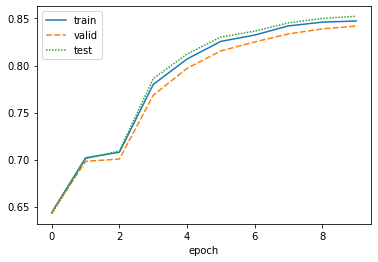

In [43]:
sns.lineplot(data=df_curves)#.figure.savefig("testfig.png")

In [44]:
test_curve

[0.6422062474039572,
 0.7006673217529658,
 0.7092759809743632,
 0.786064218318174,
 0.8121948865905241,
 0.8302895955541542,
 0.8365956291449436,
 0.8454458604976854,
 0.8500481615903748,
 0.8523912462203451]

In [45]:
df_curves

,train,valid,test
epoch,,,
0,0.644026,0.643651,0.642206
1,0.701859,0.698084,0.700667
2,0.707825,0.700562,0.709276
3,0.779873,0.768359,0.786064
4,0.806956,0.796994,0.812195
5,0.825672,0.815522,0.830290
6,0.832375,0.825082,0.836596
7,0.842119,0.833627,0.845446
8,0.846098,0.838932,0.850048
